Мохляков П.А. \
М8О-408Б-19 \
Вариант 3

## Лабораторная работа 4

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers
import tensorflow as tf
import time

Описываемм класс RBF слоя

In [4]:
class RBF(layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        super(RBF, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            shape=(input_shape[1], self.units), initializer="random_normal", trainable=True
        )
        self.sigm = self.add_weight(
            shape=(self.units,) , initializer="random_normal", trainable=True
        )
        super().build(input_shape)
        
    def call(self, inputs):
        l_norm = tf.reduce_sum((tf.expand_dims(inputs, axis=2) - self.mu) ** 2, axis = 1)
        return tf.exp(l_norm*self.sigm)

### Классификация

In [5]:
def ellipse(t, a, b, x0, y0):
    x = x0 + a*np.cos(t)
    y = x0 + b*np.sin(t)
    return x, y


def rotate(x, y, alph):
    x_ans = x*np.cos(alph) - y*np.sin(alph)
    y_ans = x*np.sin(alph) + y*np.cos(alph)
    return x_ans, y_ans

In [7]:
t = np.linspace(0, 2*np.pi, 200)
x1, y1 = ellipse(t, 0.4, 0.15, 0, 0)
x1, y1 = rotate(x1, y1, np.pi / 6)

x2, y2 = ellipse(t, 0.7, 0.5, 0, 0)
x2, y2 = rotate(x2, y2, np.pi / 3)

x3, y3 = ellipse(t, 1, 1, 0, 0)

(-1.09986915899354, 1.0999937694758828, -1.099965731583572, 1.099965731583572)

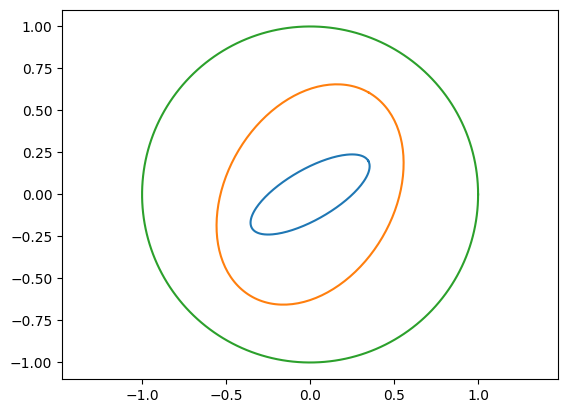

In [8]:
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.axis('equal')

Готовим датасет

In [9]:
data1 = [[cords, [1, 0, 0]] for cords in zip(x1, y1)]
data2 = [[cords, [0, 1, 0]] for cords in zip(x2, y2)]
data3 = [[cords, [0, 0, 1]] for cords in zip(x3, y3)]
dataset = data1 + data2 + data3
np.random.shuffle(dataset)

In [10]:
train_percent = 0.8
train_num = int(train_percent * len(dataset))
train_X = [x[0] for x in dataset[:train_num]]
train_y = [x[1] for x in dataset[:train_num]]
test_X = [x[0] for x in dataset[train_num:]]
test_y = [x[1] for x in dataset[train_num:]]

Создаем модель

In [12]:
predictor =  keras.Sequential([
    RBF(10,input_dim=2),
    layers.Dense(3,activation='sigmoid', name="sigmoid")
    ])
predictor.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_1 (RBF)                 (None, 10)                30        
                                                                 
 sigmoid (Dense)             (None, 3)                 33        
                                                                 
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________


Компилируем модель

In [14]:
opt = keras.optimizers.Adam(learning_rate=0.01)
predictor.compile(loss='mse', optimizer=opt, metrics=['mae'])

Тренеруем модель

Fit time: 11.09s
Result train data MSE: 5.236758806859143e-05
Result train data MAE: 0.0022640114184468985
Result test data MSE: 7.294680835912004e-05
Result test data MAE: 0.0027353838086128235


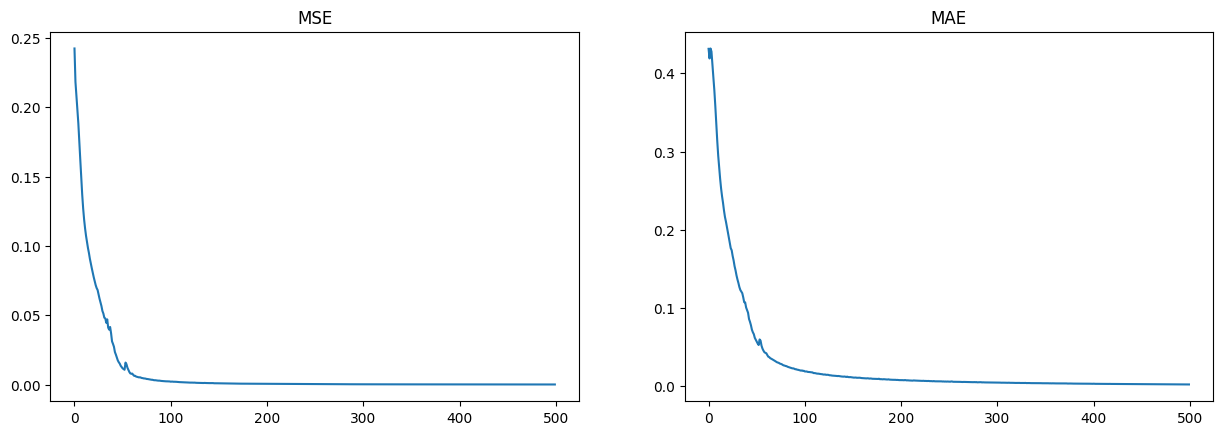

In [15]:
epochs = 500
time_start = time.time()
hist = predictor.fit(
    train_X,
    train_y,
    batch_size=len(dataset)//10,
    epochs=epochs,
    verbose=0,
    shuffle=True
    )
time_finish = time.time()
train_mse_loss, train_mae_loss = predictor.evaluate(train_X, train_y, verbose=0)
test_mse_loss, test_mae_loss = predictor.evaluate(test_X, test_y, verbose=0)

print(f'Fit time: {(time_finish - time_start):.{2}f}s')
print(f'Result train data MSE: {train_mse_loss}')
print(f'Result train data MAE: {train_mae_loss}')
print(f'Result test data MSE: {test_mse_loss}')
print(f'Result test data MAE: {test_mae_loss}')


fig, ax = plt.subplots(1, 2)
fig.set_figwidth(15)

ax[0].set_title('MSE')
ax[1].set_title('MAE')

ax[0].plot(range(epochs), hist.history['loss'])
ax[1].plot(range(epochs), hist.history['mae'])

Создаем поле точек и скалярное поле

In [16]:
pole = []
for y in np.linspace(-1,1,200):
    for x in np.linspace(-1,1,200):
        pole.append((x,y))

pred = predictor.predict(pole)
z = []
for i in range(200):
    z.append(pred[i*200: (i+1)*200])

1250/1250 [==============================] - 1s 713us/step


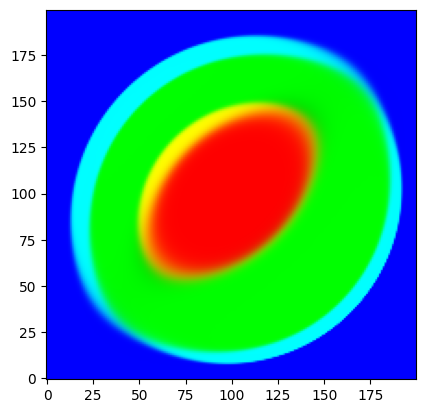

In [17]:
fig, ax = plt.subplots()
ax.imshow(z)
ax.invert_yaxis()

### Аппроксимация функции

In [18]:
def func(t):
    return np.cos(2.5*t**2 - 5*t)

In [19]:
h = 0.01
X = np.arange(0, 2.2+h,h)
y = func(X)

Создаем модель

In [28]:
predictor =  keras.Sequential([
        RBF(30,input_dim=1),
        layers.Dense(1,activation='linear', name='linear')
    ]
)
predictor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_4 (RBF)                 (None, 30)                60        
                                                                 
 linear (Dense)              (None, 1)                 31        
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


Компилируем модель

In [29]:
opt = keras.optimizers.Adam(learning_rate=0.01)
predictor.compile(loss='mse', optimizer=opt, metrics=['mae'])

Тренеруем модель

Fit time: 19.69s
Result MSE: 6.771774496883154e-05
Result MAE: 0.005920770112425089


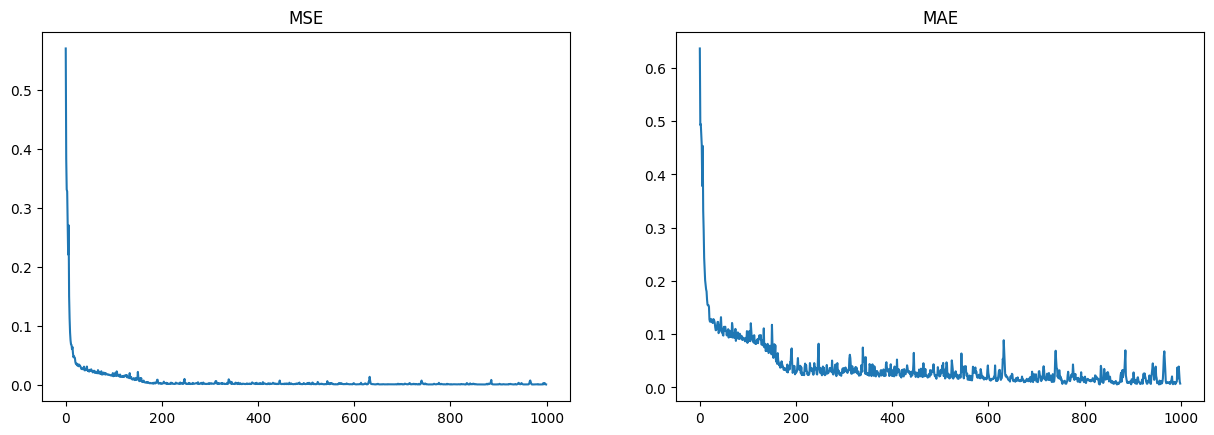

In [30]:
epochs = 1000
time_start = time.time()
hist = predictor.fit(
    X,
    y,
    batch_size=10,
    epochs=epochs,
    verbose=0,
    shuffle=True
    )
time_finish = time.time()
mse_loss, mae_loss = predictor.evaluate(X, y, verbose=0)

print(f'Fit time: {(time_finish - time_start):.{2}f}s')
print(f'Result MSE: {mse_loss}')
print(f'Result MAE: {mae_loss}')

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(15)

ax[0].set_title('MSE')
ax[1].set_title('MAE')

ax[0].plot(range(epochs), hist.history['loss'])
ax[1].plot(range(epochs), hist.history['mae'])

Аппроксимируем функцию

In [31]:
t = np.linspace(0, 2.2, 2000)
y_ans = func(t)
y_pred = predictor.predict(t)

63/63 [==============================] - 0s 685us/step


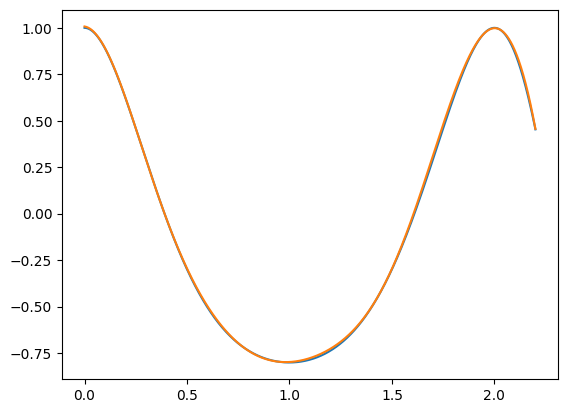

In [32]:
plt.plot(t, y_ans)
plt.plot(t, y_pred)